# 1.) Pull in Data and Convert ot Monthly

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
apple_data = yf.download('AAPL')
df = apple_data.resample("M").last()[["Adj Close"]]

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Adj Close
Date,
1980-12-31,0.117887
1981-01-31,0.097592
1981-02-28,0.091546
1981-03-31,0.084637
1981-04-30,0.098023
...,...
2023-09-30,170.984741
2023-10-31,170.545319
2023-11-30,189.949997


# 2.) Create columns. 
  - Current Stock Price, Difference in stock price, Whether it went up or down over the next month,  option premium

In [4]:
# Difference in stockprice
df["Diff"] = df["Adj Close"].diff().shift(-1)

# Target up or down
df["Target"] = np.sign(df["Diff"])

# Option Premium
df["Premium"] = 0.08 * df["Adj Close"]

(If FP, we get -100*Diff loss)

In [5]:
df

,Adj Close,Diff,Target,Premium
Date,,,,
1980-12-31,0.117887,-0.020296,-1.0,0.009431
1981-01-31,0.097592,-0.006045,-1.0,0.007807
1981-02-28,0.091546,-0.006909,-1.0,0.007324
1981-03-31,0.084637,0.013386,1.0,0.006771
1981-04-30,0.098023,0.016409,1.0,0.007842
...,...,...,...,...
2023-09-30,170.984741,-0.439423,-1.0,13.678779
2023-10-31,170.545319,19.404678,1.0,13.643625
2023-11-30,189.949997,2.580002,1.0,15.196000


# 3.) Pull in X data, normalize and build a LogReg on column 2

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [7]:
X = pd.read_csv("Xdata.csv", index_col="Date", parse_dates=["Date"])

In [8]:
y = df.loc[:"2023-09-30","Target"].copy()
df = df.loc[:"2023-09-30",:].copy()

In [9]:
logreg = LogisticRegression()

logreg.fit(X,y)

y_pred = logreg.predict(X)

In [10]:
df

,Adj Close,Diff,Target,Premium
Date,,,,
1980-12-31,0.117887,-0.020296,-1.0,0.009431
1981-01-31,0.097592,-0.006045,-1.0,0.007807
1981-02-28,0.091546,-0.006909,-1.0,0.007324
1981-03-31,0.084637,0.013386,1.0,0.006771
1981-04-30,0.098023,0.016409,1.0,0.007842
...,...,...,...,...
2023-05-31,176.778061,16.675507,1.0,14.142245
2023-06-30,193.453568,2.473389,1.0,15.476285
2023-07-31,195.926956,-8.304138,-1.0,15.674156


# 4.) Add columns, prediction and profits.

In [11]:
df["Predictions"] = y_pred

In [12]:
df

,Adj Close,Diff,Target,Premium,Predictions
Date,,,,,
1980-12-31,0.117887,-0.020296,-1.0,0.009431,-1.0
1981-01-31,0.097592,-0.006045,-1.0,0.007807,-1.0
1981-02-28,0.091546,-0.006909,-1.0,0.007324,-1.0
1981-03-31,0.084637,0.013386,1.0,0.006771,1.0
1981-04-30,0.098023,0.016409,1.0,0.007842,1.0
...,...,...,...,...,...
2023-05-31,176.778061,16.675507,1.0,14.142245,1.0
2023-06-30,193.453568,2.473389,1.0,15.476285,1.0
2023-07-31,195.926956,-8.304138,-1.0,15.674156,-1.0


In [13]:
df["Profits"] = 0.

# True Positives (Every time when we right, we get 0.08*Strike Price)
df.loc[(df["Predictions"] == 1) & (df["Target"] == 1), "Profits"] = df["Premium"]

# False Positives
df.loc[(df["Predictions"] == 1) & (df["Target"] == -1), "Profits"]= 100 * df["Diff"] + df["Premium"]



In [14]:
df

,Adj Close,Diff,Target,Premium,Predictions,Profits
Date,,,,,,
1980-12-31,0.117887,-0.020296,-1.0,0.009431,-1.0,0.000000
1981-01-31,0.097592,-0.006045,-1.0,0.007807,-1.0,0.000000
1981-02-28,0.091546,-0.006909,-1.0,0.007324,-1.0,0.000000
1981-03-31,0.084637,0.013386,1.0,0.006771,1.0,0.006771
1981-04-30,0.098023,0.016409,1.0,0.007842,1.0,0.007842
...,...,...,...,...,...,...
2023-05-31,176.778061,16.675507,1.0,14.142245,1.0,14.142245
2023-06-30,193.453568,2.473389,1.0,15.476285,1.0,15.476285
2023-07-31,195.926956,-8.304138,-1.0,15.674156,-1.0,0.000000


# 5.) Plot profits over time

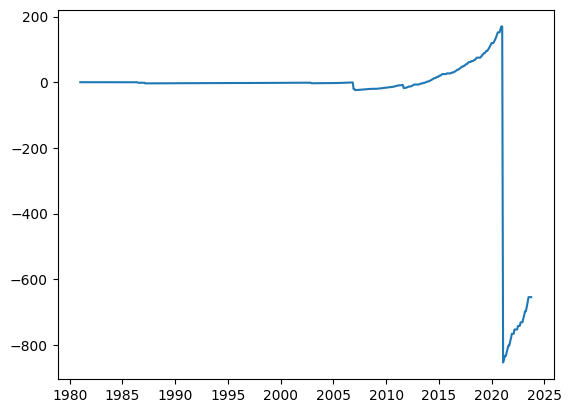

In [15]:
plt.plot(np.cumsum(df["Profits"]))

# 5.5) Short write up about how you see your skills valuable to PJ and/or Philip Liu

My background in data analytics and the quantitative skills honed through the MQE program in UCLA and previous internship experience could prove invaluable to Philip Liu and his company. With a strong command over statistical modeling and predictive analysis, particularly within economics, I am well-equipped to uncover patterns in transaction data and user behavior—key elements for the company's strategic planning and growth. Moreover, my knowledge of machine learning may offer a fresh perspective on developing intelligent systems for the company or enhancing the blockchain network. These skills are crucial for fostering data-driven decision-making and driving innovation in the blockchain sector.

# 6.) Create a loop that stores total profits over time

# 7.) What is the optimal threshold and plot the total profits for this model.